<a href="https://colab.research.google.com/github/AKSHAY-058/AKSHAY-RAJ/blob/master/GHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Python Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plot
import xgboost as xgb
import graphviz
from sklearn import preprocessing,model_selection
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Training Data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Test Data.csv")

In [ ]:
train_data.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
train_data.shape

(252000, 13)

In [ ]:
test_data.head()

,id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [ ]:
test_data.shape

(28000, 12)

In [ ]:
#shuffling the data
from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state=0)

## EDA and Feature Engineering

In [ ]:
#Checking for null values
print(train_data.isnull().any().sum())
print(test_data.isnull().any().sum())

0
0


In [ ]:
print(train_data['risk_flag'].value_counts())

0    221004
1     30996
Name: risk_flag, dtype: int64


In [ ]:
#Unique Values
print(train_data.nunique())
print('*'*50)
print(test_data.nunique())

Id                     252000
income                  41917
age                        59
experience                 21
married                     2
house_ownership             3
car_ownership               2
profession                 51
city                      317
state                      29
current_job_years          15
current_house_years         5
risk_flag                   2
dtype: int64
**************************************************
id                     28000
income                  9916
age                       59
experience                21
married                    2
house_ownership            3
car_ownership              2
profession                51
city                     317
state                     29
current_job_years         15
current_house_years        5
dtype: int64


## Complex categorical features

In [ ]:
#large number of categories
train_data[['state', 'city', 'profession']].nunique()

state          29
city          317
profession     51
dtype: int64

In [ ]:
train_data['risk_flag'].mean()

0.123

**Distribution of risk_flag grouped by categories**

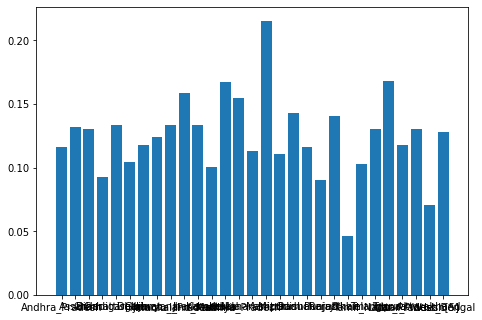

In [ ]:
import matplotlib.pyplot as plt

g_state = train_data.groupby('state')['risk_flag'].agg(['mean', 'count'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(g_state.index,g_state['mean'])
plt.show()

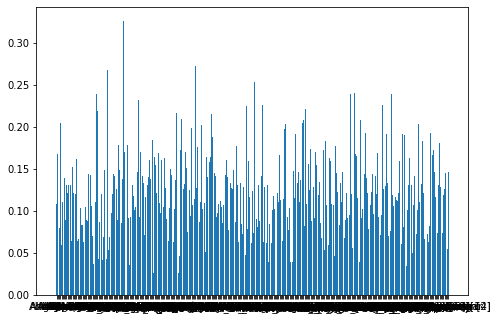

In [ ]:
import matplotlib.pyplot as plt

g_city = train_data.groupby('city')['risk_flag'].agg(['mean', 'count'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(g_city.index,g_city['mean'])
plt.show()

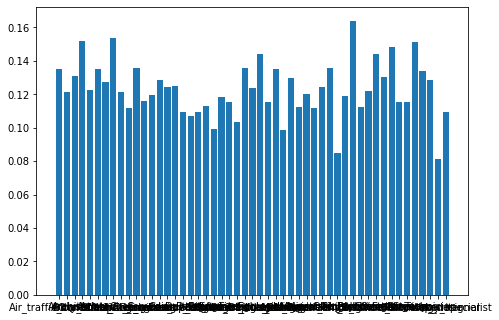

In [ ]:
import matplotlib.pyplot as plt

g_prof = train_data.groupby('profession')['risk_flag'].agg(['mean', 'count'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(g_prof.index,g_prof['mean'])
plt.show()

In [ ]:
train_data['state'].unique()

array(['Kerala', 'West_Bengal', 'Maharashtra', 'Rajasthan', 'Bihar',
       'Delhi', 'Andhra_Pradesh', 'Odisha', 'Telangana', 'Mizoram',
       'Uttar_Pradesh', 'Punjab', 'Gujarat', 'Haryana',
       'Himachal_Pradesh', 'Chhattisgarh', 'Jharkhand', 'Puducherry',
       'Karnataka', 'Tamil_Nadu', 'Manipur', 'Assam', 'Jammu_and_Kashmir',
       'Tripura', 'Madhya_Pradesh', 'Chandigarh', 'Uttarakhand',
       'Uttar_Pradesh[5]', 'Sikkim'], dtype=object)

In [ ]:
train_data['state'].replace('Uttar_Pradesh[5]', 'Uttar_Pradesh', inplace=True)

## Cleaning Test Data

In [ ]:
set1 = set(train_data['state'])
set2 = set(test_data['state'])
set1 ^ set2

{'Andhra Pradesh',
 'Andhra_Pradesh',
 'Himachal Pradesh',
 'Himachal_Pradesh',
 'Jammu and Kashmir',
 'Jammu_and_Kashmir',
 'Madhya Pradesh',
 'Madhya_Pradesh',
 'Tamil Nadu',
 'Tamil_Nadu',
 'Uttar Pradesh',
 'Uttar Pradesh[5]',
 'Uttar_Pradesh',
 'West Bengal',
 'West_Bengal'}

In [ ]:
def concat(x):
  return x.replace(' ', '_')

test_data['state'] = test_data['state'].apply(concat)
test_data['city'] = test_data['city'].apply(concat)
test_data['profession'] = test_data['profession'].apply(concat)

test_data['state'].replace('Uttar_Pradesh[5]', 'Uttar_Pradesh', inplace=True)

In [ ]:
for col in ['state', 'city', 'profession']:

  set1 = set(train_data[col])
  set2 = set(test_data[col])
  print(col,len(set1 ^ set2) )

state 0
city 0
profession 0


## Response Encoding

In [ ]:
res_state = dict(train_data.groupby('state')['risk_flag'].mean())
res_city = dict(train_data.groupby('city')['risk_flag'].mean())
res_prof = dict(train_data.groupby('profession')['risk_flag'].mean())

cat_data1 = pd.DataFrame()
cat_data1['response_state'] = train_data['state'].map(res_state)
cat_data1['response_city'] = train_data['city'].map(res_city)
cat_data1['response_prof'] = train_data['profession'].map(res_prof)

print(cat_data1.shape)
cat_data1.head()

(252000, 3)


,response_state,response_city,response_prof
117955,0.167097,0.252862,0.124048
89977,0.128135,0.178122,0.115570
86851,0.113254,0.086370,0.135789
225217,0.140833,0.238452,0.135832
186118,0.140833,0.138721,0.115385


In [ ]:
#Mapping the learnt values from training data to test 
cat_data1_test = pd.DataFrame()
cat_data1_test['response_state'] = test_data['state'].map(res_state)
cat_data1_test['response_city'] = test_data['city'].map(res_city)
cat_data1_test['response_prof'] = test_data['profession'].map(res_prof)

print(cat_data1_test.shape)
cat_data1_test.head()

(28000, 3)


,response_state,response_city,response_prof
0,0.128135,0.112277,0.144264
1,0.113254,0.108449,0.135789
2,0.113254,0.072746,0.129514
3,0.113254,0.039655,0.121465
4,0.128135,0.148101,0.119604


## One Hot Encodings

In [ ]:
state_ohe = pd.get_dummies(train_data['state'], prefix='st')
print(state_ohe.shape)

city_ohe = pd.get_dummies(train_data['city'], prefix='ct')
print(city_ohe.shape)

profession_ohe = pd.get_dummies(train_data['profession'], prefix='prf')
print(profession_ohe.shape)

(252000, 28)
(252000, 317)
(252000, 51)


In [ ]:
state_ohe_test = pd.get_dummies(test_data['state'], prefix='st')
print(state_ohe_test.shape)

city_ohe_test = pd.get_dummies(test_data['city'], prefix='ct')
print(city_ohe_test.shape)

profession_ohe_test = pd.get_dummies(test_data['profession'], prefix='prf')
print(profession_ohe_test.shape)

(28000, 28)
(28000, 317)
(28000, 51)


## Simple categorical features

**One Hot Encodings**

In [ ]:
married_ohe = pd.get_dummies(train_data['married'])
print(married_ohe.shape)
married_ohe.head()

(252000, 2)


,married,single
117955,0,1
89977,0,1
86851,0,1
225217,0,1
186118,0,1


In [ ]:
house_ohe = pd.get_dummies(train_data['house_ownership'], prefix='house')
print(house_ohe.shape)
house_ohe.head()

(252000, 3)


,house_norent_noown,house_owned,house_rented
117955,0,0,1
89977,0,0,1
86851,0,0,1
225217,0,0,1
186118,0,0,1


In [ ]:
car_ohe = pd.get_dummies(train_data['car_ownership'], prefix='car')
print(car_ohe.shape)
car_ohe.head()

(252000, 2)


,car_no,car_yes
117955,1,0
89977,1,0
86851,1,0
225217,1,0
186118,1,0


**For Test Data**

In [ ]:
married_ohe_test = pd.get_dummies(test_data['married'])
print(married_ohe_test.shape)

house_ohe_test = pd.get_dummies(test_data['house_ownership'], prefix='house')
print(house_ohe_test.shape)

car_ohe_test = pd.get_dummies(test_data['car_ownership'], prefix='car')
print(car_ohe_test.shape)

(28000, 2)
(28000, 3)
(28000, 2)


## Numerical Features

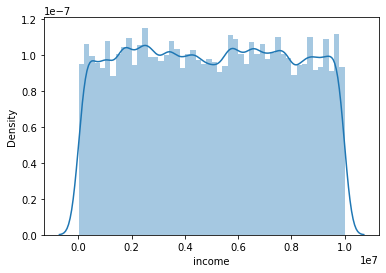

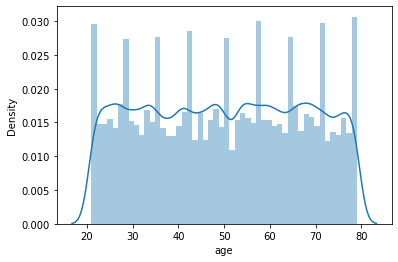

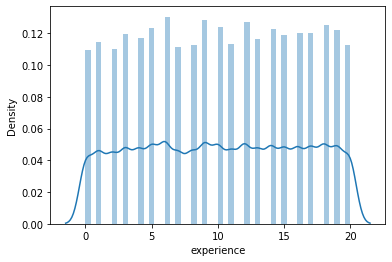

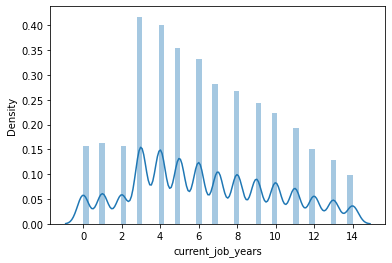

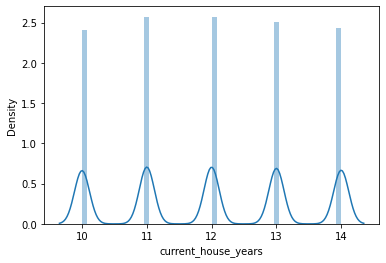

In [ ]:
num_cols = ['income', 'age', 'experience', 'current_job_years', 'current_house_years']

for each in num_cols:
    sns.distplot(train_data[each])
    plt.show()

In [ ]:
num_cols = ['income', 'age', 'experience', 'current_job_years', 'current_house_years']

#num_data1 is raw numerical data
num_data1 = train_data[num_cols].copy()
num_data1.head()

,income,age,experience,current_job_years,current_house_years
117955,6460018,75,0,0,14
89977,7134812,72,16,4,14
86851,8918340,28,13,10,14
225217,2499535,29,17,9,12
186118,270761,48,1,1,11


In [ ]:
num_data1_test = test_data[num_cols].copy()

## Column False Values

In [ ]:
zero_exp = num_data1[num_data1['experience']==0]
print(len(zero_exp))
zero_exp.head()

11043


,income,age,experience,current_job_years,current_house_years
117955,6460018,75,0,0,14
68126,4386483,37,0,0,11
100391,8683216,21,0,0,12
18717,5574828,74,0,0,10
140561,2433481,48,0,0,14


In [ ]:
len(zero_exp[zero_exp['age']>40])

7298

In [ ]:
len(zero_exp[zero_exp['current_job_years']==0])

11043

In [ ]:
len(num_data1[num_data1['current_house_years']==0])

0

In [ ]:
#Test Data
len(num_data1_test[num_data1_test['experience']==0])

1249

**Filling the values**

In [ ]:
#Replacing the zero with null values 
num_data1[['experience','current_job_years']] = num_data1[['experience','current_job_years']].replace(0, np.nan)

#Filling the null values with mean grouped by age
num_data1["experience"] = num_data1[['experience', 'age']].groupby("age").transform(lambda x: x.fillna(np.round(x.mean())))
num_data1["current_job_years"] = num_data1[['current_job_years', 'age']].groupby("age").transform(lambda x: x.fillna(np.round(x.mean())))

In [ ]:
#Replacing the zero with null values 
num_data1_test[['experience','current_job_years']] = num_data1_test[['experience','current_job_years']].replace(0, np.nan)

#Filling the null values with mean grouped by age
num_data1_test["experience"] = num_data1_test[['experience', 'age']].groupby("age").transform(lambda x: x.fillna(np.round(x.mean())))
num_data1_test["current_job_years"] = num_data1_test[['current_job_years', 'age']].groupby("age").transform(lambda x: x.fillna(np.round(x.mean())))

num_data1.head()

,income,age,experience,current_job_years,current_house_years
117955,6460018,75,11.0,7.0,14
89977,7134812,72,16.0,4.0,14
86851,8918340,28,13.0,10.0,14
225217,2499535,29,17.0,9.0,12
186118,270761,48,1.0,1.0,11


## Concatenion of the added features

In [ ]:
train_data_added = pd.concat([num_data1, 
                     cat_data1,
                     married_ohe, 
                     house_ohe, 
                     car_ohe], axis=1)

print(train_data_added.shape)
train_data_added.head()

(252000, 15)


,income,age,experience,current_job_years,current_house_years,response_state,response_city,response_prof,married,single,house_norent_noown,house_owned,house_rented,car_no,car_yes
117955,6460018,75,11.0,7.0,14,0.167097,0.252862,0.124048,0,1,0,0,1,1,0
89977,7134812,72,16.0,4.0,14,0.128135,0.178122,0.115570,0,1,0,0,1,1,0
86851,8918340,28,13.0,10.0,14,0.113254,0.086370,0.135789,0,1,0,0,1,1,0
225217,2499535,29,17.0,9.0,12,0.140833,0.238452,0.135832,0,1,0,0,1,1,0
186118,270761,48,1.0,1.0,11,0.140833,0.138721,0.115385,0,1,0,0,1,1,0


In [ ]:
xtrain = train_data_added
xtrain

,income,age,experience,current_job_years,current_house_years,response_state,response_city,response_prof,married,single,house_norent_noown,house_owned,house_rented,car_no,car_yes
117955,6460018,75,11.0,7.0,14,0.167097,0.252862,0.124048,0,1,0,0,1,1,0
89977,7134812,72,16.0,4.0,14,0.128135,0.178122,0.115570,0,1,0,0,1,1,0
86851,8918340,28,13.0,10.0,14,0.113254,0.086370,0.135789,0,1,0,0,1,1,0
225217,2499535,29,17.0,9.0,12,0.140833,0.238452,0.135832,0,1,0,0,1,1,0
186118,270761,48,1.0,1.0,11,0.140833,0.138721,0.115385,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176963,9422918,77,11.0,9.0,13,0.113254,0.088623,0.130409,0,1,0,0,1,1,0
117952,7716196,27,5.0,5.0,14,0.104554,0.123522,0.111558,0,1,0,0,1,1,0
173685,2557871,55,14.0,3.0,12,0.131691,0.104016,0.127560,0,1,0,0,1,0,1
43567,8914067,77,18.0,10.0,11,0.104554,0.154362,0.099278,0,1,0,0,1,0,1


In [ ]:
ytrain=train_data["risk_flag"]
ytrain

117955    0
89977     0
86851     0
225217    1
186118    0
         ..
176963    1
117952    1
173685    0
43567     0
199340    0
Name: risk_flag, Length: 252000, dtype: int64

In [ ]:
test_data_added = pd.concat([num_data1_test, 
                    cat_data1_test,
                    married_ohe_test, 
                    house_ohe_test, 
                    car_ohe_test], axis=1)

print(test_data_added.shape)
test_data_added.head()

(28000, 15)


,income,age,experience,current_job_years,current_house_years,response_state,response_city,response_prof,married,single,house_norent_noown,house_owned,house_rented,car_no,car_yes
0,7393090,59,19.0,4.0,13,0.128135,0.112277,0.144264,0,1,0,0,1,1,0
1,1215004,25,5.0,5.0,10,0.113254,0.108449,0.135789,0,1,0,0,1,1,0
2,8901342,50,12.0,9.0,14,0.113254,0.072746,0.129514,0,1,0,0,1,1,0
3,1944421,49,9.0,3.0,12,0.113254,0.039655,0.121465,1,0,0,0,1,0,1
4,13429,25,18.0,13.0,11,0.128135,0.148101,0.119604,0,1,0,0,1,0,1


In [ ]:
xtest = test_data_added
xtest

,income,age,experience,current_job_years,current_house_years,response_state,response_city,response_prof,married,single,house_norent_noown,house_owned,house_rented,car_no,car_yes
0,7393090,59,19.0,4.0,13,0.128135,0.112277,0.144264,0,1,0,0,1,1,0
1,1215004,25,5.0,5.0,10,0.113254,0.108449,0.135789,0,1,0,0,1,1,0
2,8901342,50,12.0,9.0,14,0.113254,0.072746,0.129514,0,1,0,0,1,1,0
3,1944421,49,9.0,3.0,12,0.113254,0.039655,0.121465,1,0,0,0,1,0,1
4,13429,25,18.0,13.0,11,0.128135,0.148101,0.119604,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,9955481,57,13.0,5.0,10,0.116022,0.064309,0.115570,0,1,0,0,1,1,0
27996,2917765,47,9.0,9.0,14,0.154369,0.191964,0.134167,0,1,0,0,1,1,0
27997,8082415,24,5.0,4.0,13,0.113254,0.038627,0.129514,0,1,0,0,1,1,0
27998,9474180,51,13.0,13.0,14,0.133281,0.141583,0.153572,0,1,0,0,1,0,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201600, 15)
(50400, 15)
(201600,)
(50400,)


In [ ]:
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [ ]:
X_train
from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
X_test


,income,age,experience,current_job_years,current_house_years,response_state,response_city,response_prof,married,single,house_norent_noown,house_owned,house_rented,car_no,car_yes
219157,8396492,33,1.0,1.0,11,0.100295,0.113580,0.099278,0,1,0,0,1,0,1
215236,8098496,77,15.0,11.0,10,0.131691,0.156174,0.152113,0,1,0,0,1,1,0
123007,5282884,72,3.0,3.0,10,0.130586,0.204651,0.112257,0,1,0,0,1,1,0
142711,9932138,45,19.0,9.0,14,0.116022,0.125427,0.135796,0,1,0,0,1,1,0
136014,3657551,27,7.0,7.0,10,0.167097,0.203333,0.127560,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240499,7446831,43,18.0,8.0,12,0.128135,0.087413,0.098667,0,1,0,0,1,1,0
111237,3879880,49,10.0,10.0,12,0.118039,0.062944,0.112257,0,1,0,0,1,1,0
233057,8715733,73,13.0,11.0,14,0.128135,0.183594,0.128289,0,1,0,0,1,0,1
87888,9777389,29,9.0,9.0,14,0.128135,0.116737,0.119604,0,1,0,1,0,1,0


In [ ]:
# Function to calculate mean absolute error
def cross_val(X_train, y_train, model):
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_cross = cross_val(X_train, y_train, model)
    
    # Return the performance metric
    return model_cross

In [ ]:
# # # Naive Bayes
# from sklearn.naive_bayes import GaussianNB
# naive = GaussianNB()
# naive_cross = fit_and_evaluate(naive)

# print('Naive Bayes Performance on the test set: Cross Validation Score = %0.4f' % naive_cross)


In [ ]:
# # Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
random_cross = fit_and_evaluate(random)

print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)

Random Forest Performance on the test set: Cross Validation Score = 0.8982


In [ ]:
# # Gradient Boosting Classification
from xgboost import XGBClassifier
gb = XGBClassifier()
gb_cross = fit_and_evaluate(gb)

print('Gradiente Boosting Classification Performance on the test set: Cross Validation Score = %0.4f' % gb_cross)

Gradiente Boosting Classification Performance on the test set: Cross Validation Score = 0.8770


In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTClassifier= DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_cross = fit_and_evaluate(DTClassifier)

print('DT Classification Performance on the test set: Cross Validation Score = %0.4f' % DTC_cross)

DT Classification Performance on the test set: Cross Validation Score = 0.8820


In [ ]:
y_pred_dt = DTClassifier.predict(xtest)

In [ ]:
y_pred_dt.mean()

0.13278571428571428

In [ ]:
y_pred_dt

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_pred_r = random.predict(xtest)

In [ ]:
y_pred_r.mean()

0.11107142857142857

In [ ]:
## y_pred_xg = gb.predict(xtest)

In [ ]:
 #y_pred_xg.mean()

In [ ]:
columns_new = ["risk_flag"]

mydf = pd.DataFrame(y_pred_r, columns = columns_new)
mydf["id"] = mydf.index+1
mydf

,risk_flag,id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
27995,0,27996
27996,0,27997
27997,0,27998
27998,0,27999


In [ ]:
columns_titles = ["id","risk_flag"]

mydf_reorder=mydf.reindex(columns=columns_titles)
mydf_reorder

,id,risk_flag
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [ ]:
print(mydf_reorder['risk_flag'].value_counts())

0    24890
1     3110
Name: risk_flag, dtype: int64


In [ ]:
mydf_reorder.to_csv('/content/drive/MyDrive/Colab Notebooks/my_subr.csv', index = False)